<a href="https://colab.research.google.com/github/cdarbelaez/SolarForecastingElecEngUdeA/blob/main/MODELOS%20SINTONIZADOS/Bayessian_Optimization_LSTM_Univariable_Array_Standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM NN MULTIVARIABLE STANDARD**

---


> En este notebook se realiza la implementación de la red neuronal mencionada: 

*   Se parte del preprocesamiento y análisis de los datos que **NO** está incluido en este script.
*   Luego se procede a cargar y escalar el dataset previamente procesado.
*   Se preparan en ventanas y se separan en set de entrenamiento y validación.
*   Luego se implementa el modelo de aprendizaje automatico con una arquitectura e hiperparametros previamente establecidos.
*   Por último se validan los resultados y se obtienen las métricas de error.

> La diferencia principal de este modelo con los demás LSTM es que se utiliza para escalar los datos la función de sklearn `StandardScaler()` y variables exogenas multiples de entrada al modelo.

---

**BASE DE DATOS:** KENYA



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU



---
# 1.   **SE IMPORTAN LAS BIBLIOTECAS NECESARIAS**

---


  Importamos las librerias necesarias para todo el script: 

1.   **Matplotlib** para realizar las gráficas
2.   **Pandas** para procesar la base de datos
3.   **Numpy** para convertir la base de datos en arreglos numéricos
4.   **Os** para acceder a los archivos mediante rutas de almacenamiento
5.   **Seaborn** para realizar análisis gráficos a los datos mediante análisis estadisticos
6.   **Drive** se utiliza para acceder a las carpetas de datos del drive de un correo asociado
7.   **Tensorflow** es la librería mediante la cual se generan los modelos de redes neuronales



In [ ]:
pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 13.5 MB/s 


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from kerastuner import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from google.colab import drive 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False



---


# 2.   **SE CARGA EL DATASET PREVIAMENTE PROCESADO**

---




En la siguiente celda de codigo se llama una función de google colab mediante la cual se accede a la carpeta de drive, luego se define la ruta de acceso a la base de datos previamente procesados para la realización del modelo y se procesa mediante la librería `Pandas`:

In [ ]:
#uta= 'https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv'
ruta='https://raw.githubusercontent.com/cdarbelaez/SolarForecastingElecEngUdeA/main/DATABASES/KENYA_LIMPIO.csv'
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  data.set_index('datetime', inplace=True)
else:
  data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head(2) # Se muestran las 5 primeras filas del dataframe

,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
time,,,,,,,,,,,,,,
2019-12-12 00:00:00,0.0,0.0,0.0,22.72500,99.003998,948.445923,0.0,1.073283,169.845993,0.0,0.0,0.0,0.0,0
2019-12-12 00:15:00,0.0,0.0,0.0,22.58083,98.758003,948.415283,0.0,0.727417,204.165405,0.0,0.0,0.0,0.0,0


In [ ]:
data.describe()

,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
count,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000,37054.000000
mean,101.605565,312.172581,309.670420,28.155852,56.580758,948.982794,0.001695,3.396610,173.334919,302.680626,295.238950,297.736465,0.010309,11.499325
std,139.573087,412.482701,409.789373,3.718118,16.149962,2.106035,0.028706,1.369756,57.881838,406.842824,398.286860,400.896819,0.101011,6.922606
min,0.000000,0.000000,0.000000,19.698168,19.586000,940.572571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,25.100708,43.253499,947.504150,0.000000,2.353667,137.821041,0.000000,0.000000,0.000000,0.000000,5.000000
50%,11.046591,10.828959,8.932726,27.863417,55.611500,949.026123,0.000000,3.487000,159.992706,9.340188,9.207122,9.209722,0.000000,11.000000
75%,172.263950,653.564713,648.214691,31.162791,68.082001,950.483368,0.000000,4.407000,196.755257,628.698654,609.180679,616.042496,0.000000,17.750000
max,725.770264,1549.640381,1545.945801,38.692162,99.612999,955.456482,1.800000,10.540333,359.996918,1587.108887,1583.939087,1577.821777,1.000000,23.000000




---


# 3. **SE SELECCIONAN LOS DATOS A UTILIZAR PARA EL ENTRENAMIENTO DEL MODELO**


---



Luego de analizar las corelaciones, se llego a la conclusion de que los datos que más influencia tienen sobre los valores de irradianza `GHI` son los que se seleccionaron y se colocaron en un nuevo dataset:



In [ ]:
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  features_considered = ['GHI','Precipitation',	'DOY','PST','Precipitation', 'Zenith',	'Humidity'] 
  features = data[features_considered].loc['2010-04-07 00:00:00':] # Creamos un dataframe con solo estos datos
else:
  features_considered = ['ghi_pyr_1']#,'precipitation','relative_humidity','Hour','wind_speed']
  features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos

,ghi_pyr_1
time,
2019-12-12 00:00:00,0.0
2019-12-12 00:15:00,0.0
2019-12-12 00:30:00,0.0
2019-12-12 00:45:00,0.0
2019-12-12 01:00:00,0.0


Graficamos todos los datos con el fin de apreciar de manera general su comportamiento a lo largo del tiempo con la función plot asociada a la librería `Pandas`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7b48fb150>],
      dtype=object)

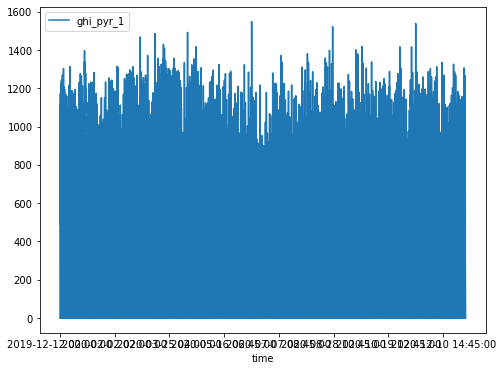

In [ ]:
features.plot(subplots=True) # Graficamos las columnas de datos para observar su comportamiento

Se convierte el conjunto de datos en un arreglo de `numpy` definiendo la cantidad de datos que se van a utilizar para el proceso y luego se estandarizan con una normalización:




---


3_1. **ESCALAMIENTO DE LOS DATOS**


---


In [ ]:
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  estandar=data['GHI'].values.reshape(len(data),1)
else:
  estandar=data['ghi_pyr_1'].values.reshape(len(data),1)
scaler = StandardScaler()
dataset = scaler.fit_transform(estandar)

In [ ]:
TRAIN_SPLIT = int(len(features)*0.8//1) #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
STEP=1
dataset = features.values # Convertimos el dataframe en un arreglo de numpy
data_mean = dataset[:TRAIN_SPLIT,0].mean(axis=0) # Se obtiene la media estadistica de los datos
data_std = dataset[:TRAIN_SPLIT,0].std(axis=0) # Se obtiene la desviación estandar de los datos

dataset = (dataset-data_mean)/data_std #Se normaliza cada dato del arreglo para que todos los valores esten entre -1 y 1





---


# 4.   **SE DEFINE LA FUNCIÓN QUE SE UTILIZA PARA LA PARTICIÓN DE LOS DATOS EN VENTANAS**

--- 

In [ ]:
#---------------------------------------
#CONFIGURACIÓN DE LAS VENTANAS DE DATOS#
#---------------------------------------
DATASPLIT = 0.8                        #
Num_datos_entrada = 96                 #
Num_datos_salida = 96                  #
#---------------------------------------

def ventanas(dataset,xsize,ysize,split,validation= False):
  #dataset: Es un array de numpy obtenido a partir del dataframe de pandas, en este están contenidos todos los datos que se utilizarán
  #split: porcentaje del dataset a utilizar
  #xsize: Número entero, determina el tamaño de la ventana de caracteristicas (Entradas del modelo)
  #ysize: Número entero, determina el tamaño de la ventana de etiquetas (Salidas del modelo)
  #validation: Si es True, toma el porcentaje restante de los datos como set, de lo contrario toma el porcentaje indicado

  if validation!=True: #Se generan los índices para tomar los días exactos para el set de entrenamiento
    indexin=int(0)
    indexf=int((((len(dataset)*split)//xsize)*xsize))
  else: #Se generan los índices para tomar los días exactos para el set de validación
    indexin=int((((len(dataset)*split)//xsize)*xsize))
    indexf=int(len(dataset))
  n=0 # Indexador
  x=[] # Lista vacia donde estarán contenidas las ventanas de datos de entrada (Caracteristicas)
  y=[] # Lista vacia donde estarán contenidas las ventanas de datos de salida (Etiquetas)
  
  for i in range(int(((indexf-indexin)/ysize)-1)): #Este ciclo se repite el número de veces como ventanas habrán en un arreglo de datos
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # indexf=6, indexin=0, xsize=2, ysize=2
                                                   # range= (3-1) = 2  <------ Ya que se obtendrán 3 ventanas de datos
                                                   # Al resultado se le resta uno para considerar que la ultima ventana tambien contenga datos en "y"
                                                   
    x.append(dataset[n+indexin:n+indexin+xsize].T) #Se agrega a la lista la ventana de datos utilizando la idexación 
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # Primera iteración:
                                                   #  x=[[1,2]]
                                                   # Segunda iteración:
                                                   #  x=[[1,2],[3,4]]

    y.append(dataset[n+indexin+xsize:n+indexin+xsize+ysize].T[0])
                                                   # Siguiendo el ejemplo anterior
                                                   #  y=[[3,4]]
                                                   # Segunda iteración:
                                                   #  y=[[3,4],[5,6]]
    
                                                   # Siguiento el ejemplo, los las ventanas listas para entrar al modelo quedan de la siguiente manera
                                                   # x = [[1,2],[3,4]]
                                                   # y = [[3,4],[5,6]]

    n+=ysize # Se suma al indexador el tamaño de la ventana
    
  return np.array(x),np.array(y)

x_train1, y_train1= ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT)
x_val1,y_val1=ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT, validation=True)


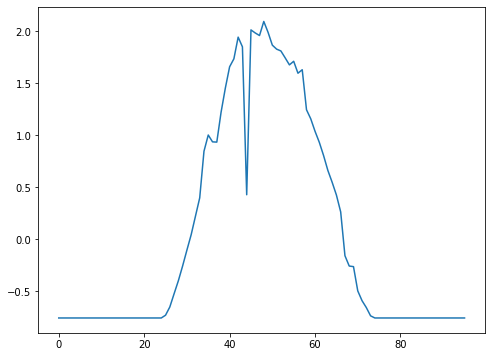

In [ ]:
plt.plot(x_train1[0][0])#,y_train1[0]




---


# 5.   **FUNCIÓN PARA VISUALIZAR LOS RESULTADOS OBTENIDOS**


---



La siguiente de función se utiliza para generar gráficos a partir de una ventana de tiempo como las que se definieron anteriormente, esta se utilizará para mostrar:

*   La ventana de tiempo utilizada para la predicción
*   El valor real de los datos futuros tomado del set de validación
*   El valor de las predicciones que arroja la red neuronal



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, (true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, (prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica

---
 # 6. **CREACIÓN Y ENTRENAMIENTO DEL MODELO**

---

**LSTM**: estas redes resuelven el problema de las redes recurrentes convencionales, ya que estas tienen como característica principal que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden recordar estados previos y utilizar esta información para decidir cuál será el siguiente.

En las siguientes celdas se va a definir el modelo de ML que se utilizará para realizar las predicciones buscadas, este modelo consta de una capa de entrada, y dos capas intermedias de neuronas tipo LSTM, con una respectiva función de activación.

![RedNeuronalArtificial.png](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1024px-LSTM_Cell.svg.png)

Fig 1. [Arquitectura de la red LSTM](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1024px-LSTM_Cell.svg.png)



La cantidad de neuronas ajustada de forma manual para maximizar su precisión de entrenamiento y una capa de salida con n neuronas con n datos de predicción buscados.

Además se compila el modelo y dentro de dicha compilación estan incluidas configuraciónes, donde las configuraciones son:

*   **optimizer**: Optimizador utilizado Adam
*   **loss**: Métrica utilizada para determinar las perdidas del modelo es mean_absolute_error
*   **metrics**: Guarda los valores de las metricas en cada epoca de entrenamiento






In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.01):
      print("\nReached less than 0.01 losses so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
batch_size=1

In [ ]:
def build_model(hp):
  activacion = hp.Choice('Activacion', ['tanh', 'relu', 'sigmoid', 'softmax', 'gelu', 'elu'])                                
  neuronas_c1 = hp.Int('Units1', min_value = 20, max_value = 200, step = 20)
  neuronas_c2 = hp.Int('Units2', min_value = 20, max_value = 200, step = 20)
  dropout = hp.Float('Dropout', min_value = 0, max_value = 0.3, step = 0.05)
  model = tf.keras.models.Sequential([  
      tf.keras.layers.LSTM(neuronas_c1, activation = activacion, stateful= True, batch_input_shape= (batch_size, x_train1.shape[1], x_train1.shape[2]),  dropout=dropout, return_sequences=True),
      tf.keras.layers.LSTM(neuronas_c2, activation= activacion, stateful= True, dropout=dropout),
      tf.keras.layers.Dense(96,activation=activacion)
  ])
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
  hp_optimizers = hp.Choice('Optimizer', values = ['adam', 'adamax','nadam','RMSprop','SGD'])
  if hp_optimizers == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  if hp_optimizers == 'adamax':
    opt = tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  if hp_optimizers == 'nadam':
    opt = tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate)
  if hp_optimizers == 'RMSprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
  if hp_optimizers == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  model.compile(optimizer=opt, loss='mean_absolute_error',metrics=["accuracy"])
  return model

**Sintonización del modelo utilizando optimización bayesiana**

La tecnica de optimización bayesiana tiene una ventaja y es que soluciona el problema que presenta randomsearch e hyperband. Este no escoge las combinaciones aleatoriamente, lo cual no garantiza hiperparametros optimos en algunos casos, por el contrario, la **BayesianOptimization** elije las primeras combinaciones al azar y utiliza el rendimiento de estas para elejir los siguientes mejores hiperparametros. Esto lo hace una tecnica con memoria, utilizando el historial de hiperparametros probados, para encontrar los optimos.

los parametros de BayesianOptimization son:

* **Hypermodel** : una HyperModel instancia (o invocable que toma hiperparámetros y devuelve una instancia de modelo).
* **objective** : Una cadena o keras_tuner.Objective instancia. Si es una cadena, se deducirá la dirección de la optimización (mín. o máx.).
* **max_trials** : Entero, el número total de pruebas (configuraciones del modelo) para probar como máximo. Tenga en cuenta que el oráculo puede interrumpir la búsqueda antes de max_trial que se hayan probado los modelos si se ha agotado el espacio de búsqueda.
* **num_initial_points** : número opcional de muestras generadas aleatoriamente como datos de entrenamiento inicial para la optimización bayesiana. Si no se especifica, se utiliza un valor de 3 veces la dimensionalidad del espacio de hiperparámetros.
* **alpha** : Flotante, el valor agregado a la diagonal de la matriz del kernel durante el ajuste. Representa la cantidad esperada de ruido en los rendimientos observados en la optimización bayesiana. El valor predeterminado es 1e-4.
* **beta** : Flotación, el factor de equilibrio de la exploración y la explotación. Cuanto más grande es, más exploratorio es. El valor predeterminado es 2.6.
* **seed** : Entero opcional, la semilla aleatoria.
* **HyperParameters** : instancia opcional . Se puede usar para anular (o registrar por adelantado) hiperparámetros en el espacio de búsqueda.
* **tune_new_entries** : booleano, si las entradas de hiperparámetro solicitadas por el hipermodelo pero que no se especificaron hyperparametersdeben agregarse al espacio de búsqueda o no. De lo contrario, se utilizará el valor predeterminado para estos parámetros. El valor predeterminado es Verdadero.
* **allow_new_entries** : booleano, si el hipermodelo puede solicitar entradas de hiperparámetros que no figuran en hyperparameters. El valor predeterminado es Verdadero.
* **kwargs** : argumentos de palabras clave relevantes para todas las Tuner subclases. 

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective = 'loss',
    max_trials = 200,
    executions_per_trial = 1,
    directory = 'my_dir1',
    overwrite = True
)
tuner.search_space_summary()    

Search space summary
Default search space size: 6
Activacion (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'sigmoid', 'softmax', 'gelu', 'elu'], 'ordered': False}
Units1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
Units2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07], 'ordered': True}
Optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamax', 'nadam', 'RMSprop', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(x_train1, y_train1, epochs = 200, validation_data=(x_val1, y_val1))


Trial 200 Complete [00h 00m 14s]
loss: 0.15278376638889313

Best loss So Far: 0.1522592157125473
Total elapsed time: 01h 14m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'Activacion': 'elu', 'Units1': 20, 'Units2': 20, 'Dropout': 0.0, 'learning_rate': 0.01, 'Optimizer': 'adam'}


In [ ]:
n_best_models = tuner.get_best_models(num_models =2)
print(n_best_models[0].summary())
print(n_best_models[1].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 20)                9360      
                                                                 
 lstm_1 (LSTM)               (1, 20)                   3280      
                                                                 
 dense (Dense)               (1, 96)                   2016      
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 20)                9360      
                                                                 
 lstm_1 (LSTM)             

In [ ]:
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(x_train1, y_train1, epochs=300, verbose=1, validation_data=(x_val1, y_val1), batch_size=batch_size, shuffle=False, callbacks=[callbacks])

Epoch 1/300
307/307 [==============================] - 2s 3ms/step - loss: 0.1680 - accuracy: 0.1042 - val_loss: 0.1034 - val_accuracy: 0.1579
Epoch 2/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1357 - accuracy: 0.1531 - val_loss: 0.1022 - val_accuracy: 0.1447
Epoch 3/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1346 - accuracy: 0.1368 - val_loss: 0.1008 - val_accuracy: 0.1579
Epoch 4/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1348 - accuracy: 0.1303 - val_loss: 0.1019 - val_accuracy: 0.0921
Epoch 5/300
307/307 [==============================] - 1s 3ms/step - loss: 0.1346 - accuracy: 0.1303 - val_loss: 0.1009 - val_accuracy: 0.1053
Epoch 6/300
307/307 [==============================] - 1s 3ms/step - loss: 0.1327 - accuracy: 0.1205 - val_loss: 0.0995 - val_accuracy: 0.1184
Epoch 7/300
307/307 [==============================] - 1s 3ms/step - loss: 0.1322 - accuracy: 0.1270 - val_loss: 0.0994 - val_accuracy: 0.0526

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 20)                9360      
                                                                 
 lstm_3 (LSTM)               (1, 20)                   3280      
                                                                 
 dense_1 (Dense)             (1, 96)                   2016      
                                                                 
Total params: 14,656
Trainable params: 14,656
Non-trainable params: 0
_________________________________________________________________



---


# 7. **RESULTADOS** 📃


---


En esta sección del codigo se observarán y analizarán los resultados obtenidos realizando predicciones con el modelo que generamos.  ✌

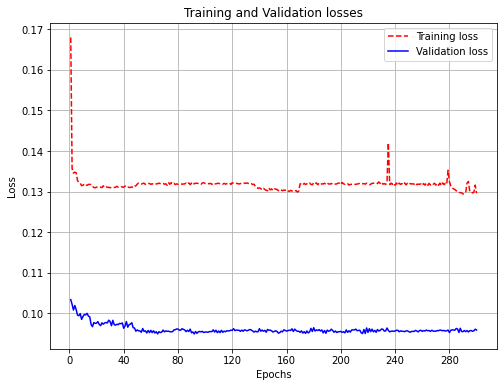

<Figure size 576x432 with 0 Axes>

In [ ]:
def metricas(history):
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]


  epochs   = range(1,len(loss)+1,1)
  plt.plot ( epochs,     loss, 'r--', label='Training loss' )
  plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.title ('Training and Validation losses'   )
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.grid(True)

  plt.legend()
  plt.figure() 

metricas(history)

In [ ]:
n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_train1)):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
tMAPE =np.array(MAPE).mean()
tMAE =np.array(MAE).mean()
tRMSE =np.array(RMSE).mean()

n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_val1)):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
  
vMAPE =np.array(MAPE).mean()
vMAE =np.array(MAE).mean()
vRMSE =np.array(RMSE).mean()

In [ ]:
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(tMAE,tMAPE,tRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(vMAE,vMAPE,vRMSE))
print("----------------------------------")

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  68.3935      0.3404    119.4686
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  39.5520      0.1611     76.6061
----------------------------------


----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
   40.4231     13.9251     78.5699
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  40.5472     16.6566     77.4171
----------------------------------

**CON LOS DATOS DE ENTRENAMIENTO**

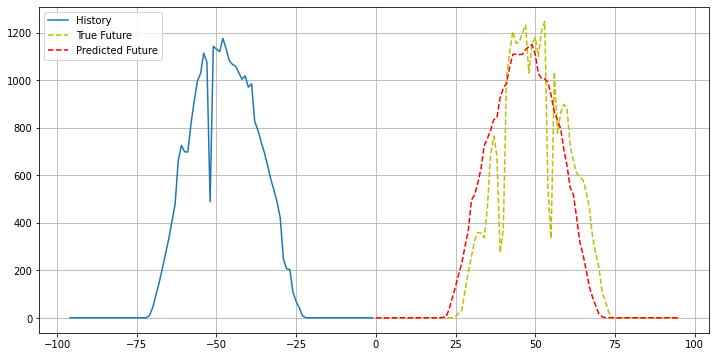

El MAPE para un horizonte de 24h es: 2.5606668020430154 %


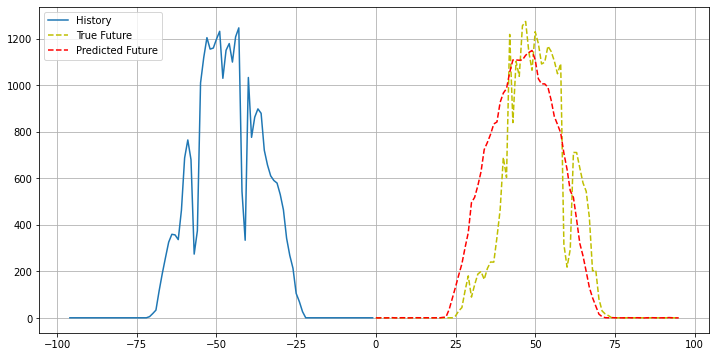

El MAPE para un horizonte de 24h es: 9.357348055717145 %


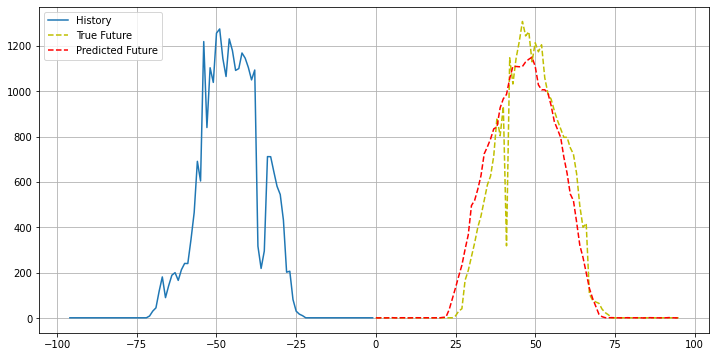

El MAPE para un horizonte de 24h es: 0.9265289160408563 %


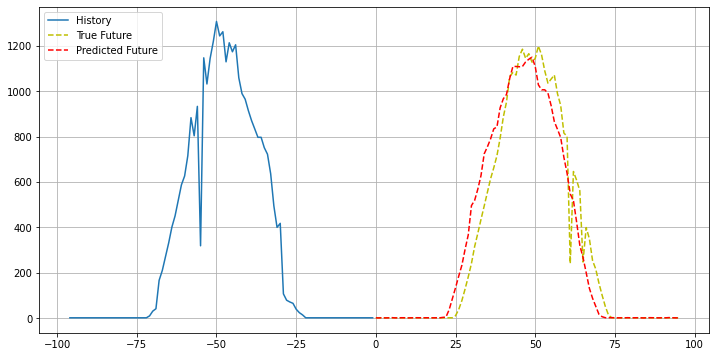

El MAPE para un horizonte de 24h es: 0.45983324482429055 %


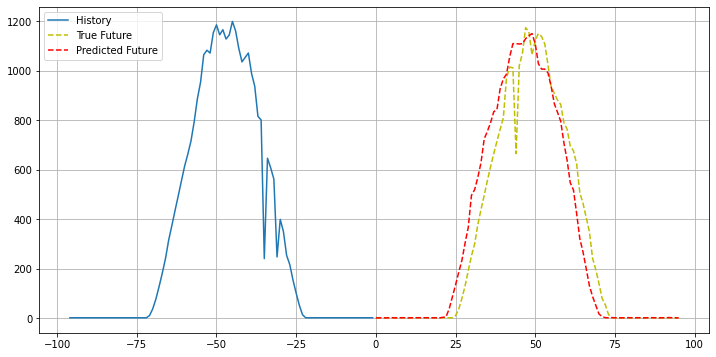

El MAPE para un horizonte de 24h es: 2.7144982200956385 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1

**CON LOS DATOS DE VALIDACIÓN**

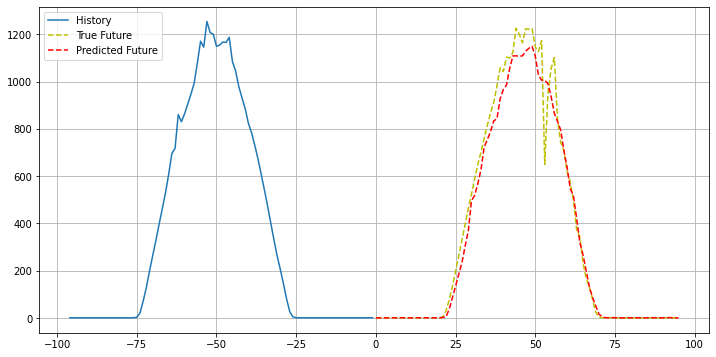

El MAPE para un horizonte de 24h es: 5.428844513131981 %


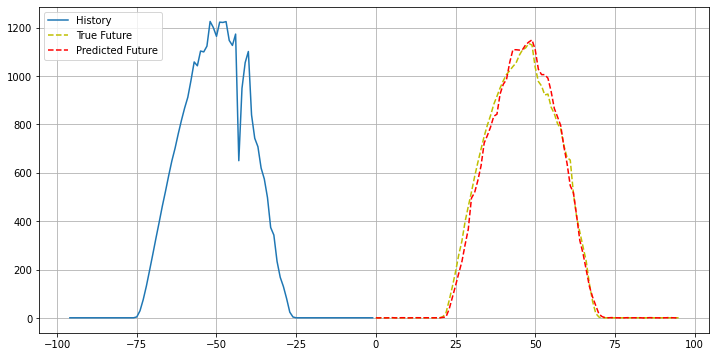

El MAPE para un horizonte de 24h es: 1.3750199439366368 %


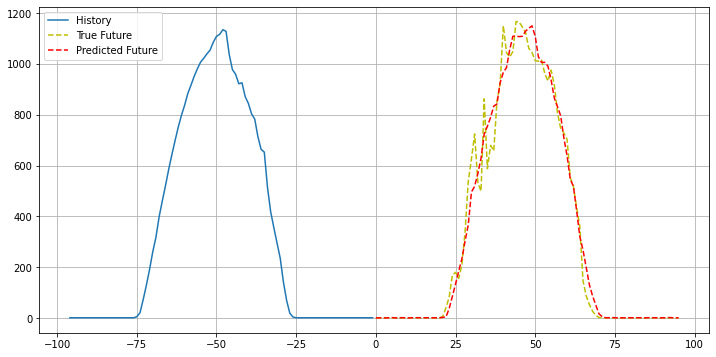

El MAPE para un horizonte de 24h es: 0.33346217333578737 %


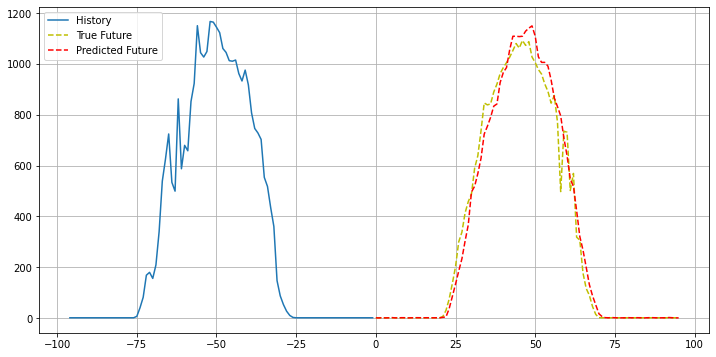

El MAPE para un horizonte de 24h es: 0.5739000675816458 %


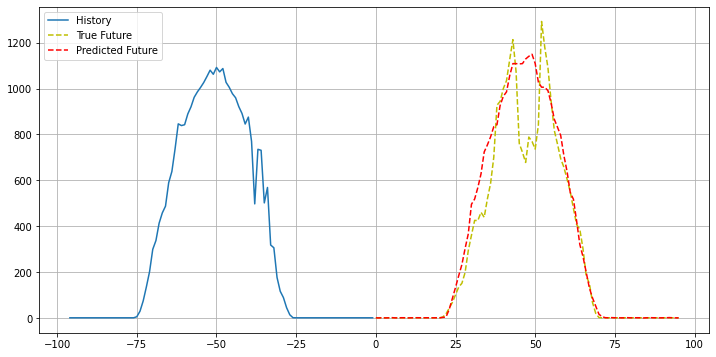

El MAPE para un horizonte de 24h es: 9.203359118903427 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1